In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import generate_timestep
from tqdm import tqdm

hydra.initialize(config_path="cfg_long_hal", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=KS", "nt=131"])

In [3]:
with h5py.File(cfg.dataset.train_path, 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)

In [4]:

x = traj[0, :1, :]
solution = []
y_pred = x
solution.append(y_pred)
for i in tqdm(range(cfg.nt-1)):
    y_pred = generate_timestep(y_pred, 0, cfg)
    solution.append(y_pred)
solution = torch.cat(solution, dim=0)

real = traj[0, :131, :]


  5%|▌         | 7/130 [14:34<3:52:17, 113.32s/it]

In [ ]:
print(torch.norm(real-solution)/ torch.norm(real))

tensor(2.7781e-05)


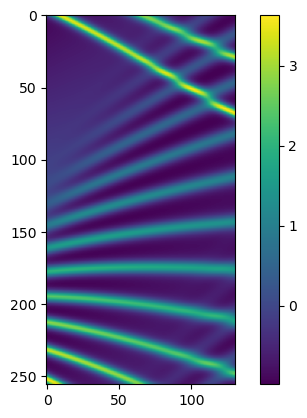

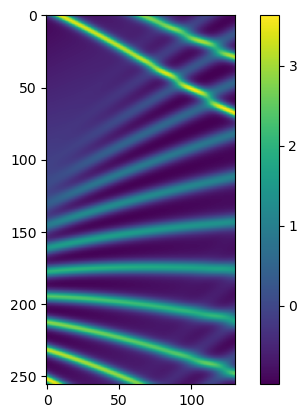

In [ ]:
plt.figure()
plt.imshow(real.cpu().numpy().T)
plt.colorbar()

plt.figure()
plt.imshow(solution.cpu().numpy().T)
plt.colorbar()